In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from glob import glob
import IPython.display as ipd
import librosa
import keras
import tensorflow as tf
import soundfile as sf

tf.random.set_seed(999)
np.random.seed(999)

Сперва необходимо запустить ноутбук prepare_dataset, и выполнить необходимые преобразования.

In [5]:
window_length = 256

overlap = round(0.25 * window_length) # overlap of 75%

n_fft = window_length

feature_sample = 16000

n_features = n_fft//2 + 1

n_segments = 8

n_clean_segments = 1

In [6]:
# Get test data
demonstration = pickle.load(open('x_test.pkl', 'rb'))
phase = pickle.load(open('phase.pkl', 'rb'))
params = pickle.load(open('params.pkl', 'rb'))

demonstration = np.asarray(demonstration).astype('float32')

In [7]:
# Model testing
model = keras.models.load_model('speech_model.h5')

print(demonstration.shape)
result_from_model = model.predict(demonstration)
result_from_model.shape

2023-04-18 22:59:22.756599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: fedora
2023-04-18 22:59:22.756628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: fedora
2023-04-18 22:59:22.756716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-04-18 22:59:22.756752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.41.3


(833, 129, 8, 1)
27/27 [==============================] - 1s 12ms/step


(833, 129, 1, 1)

In [8]:
# restore denoised file to wav format
clean_mean = params[0] # tooked from data preparation file
clean_std = params[1]
 
def read_audio(filepath, sample_rate, normalize=True):
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr


def get_audio_from_stft_spectrogram(stft_features):
        return librosa.istft(stft_features, win_length=window_length, hop_length=overlap,
                             window='hamming', center=True)


def show_spectrogram(spectrogram, title):
    result = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max).astype(np.float32)
    plt.figure(figsize=(10,4))
    plt.imshow(result)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    

def revert_features_to_audio(features, phase, mean=None, std=None):
    # scale the outpus back to the original range
    if mean and std:
        features = std * features + mean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done
    
    features = np.transpose(features, (1, 0))
    
    show_spectrogram(features, "Denoised stft")
    
    return get_audio_from_stft_spectrogram(features)

Min: -0.3139462 Max: 0.21236244


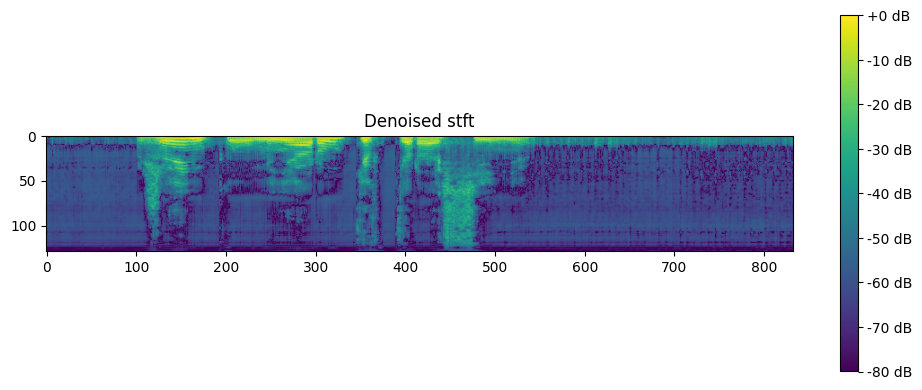

In [9]:
denoised = revert_features_to_audio(result_from_model, phase, clean_mean, clean_std)
print("Min:", np.min(denoised),"Max:",np.max(denoised))

ipd.Audio(data=denoised, rate=feature_sample) # show wav file

In [11]:
sf.write('denoised_file_example.wav',denoised, feature_sample)